In [1]:
# import packages
import numpy as np
import scipy
from scipy.stats import norm 
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import math

# Univariate Normal

## Inverse Transform Sampling 

Let $u \sim uniform(0,1)$ and $f \sim normal(0,1)$. Let $F$ be the cumulatitive distribution function (cdf) of $f$, and $F^{-1}$ be the quantile function of $f$ (inverse of the cdf). 

We want to simulate $x$ with the cdf $F(x) = P(X \leq x)$. 

Let $X=F^{-1}(u)$. Then $F(x) = P(X \leq x) = P(F^{-1}(u) \leq x) = P(u \leq F(x))$. The pdf of $u(x)$ is defined by
$$
u(x)=\begin{cases}
1&\text{if}\quad 0\leq x\leq 1\\
0&\text{otherwise}
\end{cases}.
$$
Thus $F(x) = 1*F(x) = F(x)$. 

Therefore, we can simulate a standard normal distribution by $F^{-1}(u)$. 

In [ ]:
# generate sample from normal distribution using inverse transform sampling 
def InverseTransform(mu, sigma, n_samples):

  # start counter
  tic = time.perf_counter() 

  # simulate uniformly randomly distributed data of size n_samples
  u = np.random.uniform(0, 1, n_samples)

  # perform inverse transform sampling, scale by sigma, and translate by mu
  x = norm.ppf(u) * sigma + mu # quantile of standard normal distribution, scaled

  # end counter
  toc = time.perf_counter()

  # plot histogram of generated data
  plt.hist(x)
  plt.show()

  # plot qqplot of generated data
  sm.qqplot(x) #defaut comparison distribution is standard normal
  plt.show()

  # extract mean and standard deviation from generated data
  mu_new, sigma_new = norm.fit(x)

  # print given and generated parameters
  print("univariate inverse transform took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters

  return x


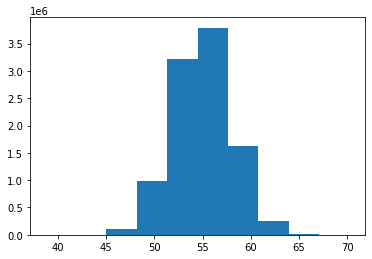

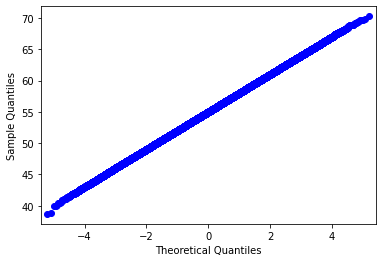

univariate inverse transform took 1.3456765069999932 seconds
given: mu = 55, sigma = 3
generated: mu = 54.99907290248596, sigma = 2.999968963583536


In [ ]:
# test generator
InverseTransform(55, 3, 10000000)

## Box Muller Transform

### Explanation
Suppose $u,v \sim  N(0,1)$ and $u$ and $v$ are independent. Then $f_u(x) = f_v(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$. The joint distribution of $u$ and $v$ is 

$$f_{u,v}(u,v) = f_u(u) \cdot f_v(v) = \frac{1}{2\pi}e^{-\frac{(u^2+v^2)}{2}}.$$ 


Let $T(\theta,r)$ be defined by

$$T(\theta, r) =\binom{u(\theta,r)}{v(\theta,r)} = \binom uv = \binom{r\cos\theta}{r\sin\theta}$$

From this, we want to find the density of $r$ and $\theta$ in terms of $u$ and $v$. We compute in advance

\begin{align}
det(T) &= det\begin{bmatrix}\cos\theta&-r\sin\theta\\\sin\theta&r\cos\theta\end{bmatrix} \\
&= r(\cos\theta)^2-(-r(\sin\theta)^2 = r(\cos^2\theta+\sin^2\theta)\\
&=r 
\end{align}

Then,

\begin{align}
f_{\theta,r}(\theta,r)
&= | det(T) |\cdot f_{u,v}(T(\theta,r))\\
&=r\frac{1}{2\pi}e^{-\frac12\left((r\cos\theta)^2 +(r\sin\theta)^2 \right)}\\
&=r\frac{1}{2\pi}e^{-\frac12r^2}\\
&= \underbrace{\frac{1}{2\pi}\mathbb{I}_{[0,2\pi]}(\theta)}_{\text{density of } \theta\in[0,2\pi]}\cdot \underbrace{re^{-\frac12r^2}}_{\text{density of } r}\\
\end{align}

Since $u$ and $v$ lie on the coordinate plane, we have $ u^2+v^2 = r^2$. Since $u,v \sim  N(0,1)$, then $r^2 \sim \chi^2_2 = \Gamma(1,\frac{1}{2}) = exp(\frac{1}{2}) $. So $r \sim \sqrt{2exp(1)}$. 

The cdf of $r$ is given by

$$ G_\sqrt{2exp(1)} (r)  = P(\sqrt{2exp(1)}  \leq r) = P(exp(1) \leq \frac{r^2}{2}) = 1-e^{-\frac{r^2}{2}}.$$

The pdf of $r$ is given by the derivative of the cdf
$$\frac{dG_\sqrt{2exp(1)}(r)}{dr} = -e^{-\frac{r^2}{2}}(-r) = re^{-\frac{r^2}{2}}  = f_\sqrt{2exp(1)}(r) $$

Thus, $re^{-\frac{r^2}{2}}$ is the distribution of $r$. 

$\frac{1}{2\pi}\mathbb{I}_{[0,2\pi]}(\theta)$ is the uniform distribution on the interval $[0, 2\pi]$, so $\theta \sim uniform(0,2\pi) $.

Therefore, since $T(\theta,r )$ is the product of the distribution of $\theta $ and the distribution of $r$, then $\theta$ and $r$ are independent.

An immediate consquence of the independence of $\theta$ and $r$ is that they can be simulated independently in order to simulate a normal distribution. 

To simulate $r$, we can use inverse transform sampling. 
Since $r^2 \sim exp(\frac{1}{2}) $, then $r^2 = H^{-1}_{\frac{1}{2}}(u_1)$ where $u_1 \sim uniform(0,1)$ and $H$ is the cdf of $exp(\frac{1}{2})$.

$H_{\frac{1}{2}}(u_1) = 1-e^{-\frac{u_1}{2}}$ so $H^{-1}_{\frac{1}{2}}(u_1) = -2ln(1-u_1)$. 

To simulate $\theta \sim uniform(0,2\pi) $ with $u_2 \sim uniform(0,1)$, we can transform $u_2$. Then $\theta  = 2\pi u_2$. 

Note: $u_1$ and $u_2$ are independent because $\theta$ and $r$ are independent. 

We use $\theta$ and $r$ to calculcate $u = rcos(\theta)$ and $v = rsin(\theta)$ where $u,v \sim N(0,1) $


### Implementation

In [7]:
# generate sample from normal distribution using Box-Muller Transform
def BoxMuller(mu,sigma,n,plot=False):
  
  # start counter
    tic = time.perf_counter() 

  # simulate theta and r
    u1, u2 = np.random.uniform(0,1,n), np.random.uniform(0,1,n)
    r = np.sqrt(-2*np.log(1-u1))
    theta = 2*np.pi*u2

  # calculcate x coordinate
    x = np.cos(theta)*r*sigma + mu

    # end counter
    toc = time.perf_counter() 

    if plot == True:

        # plot histogram of generated data
        plt.hist(x,density=True)
        plt.show()

        # plot qqplot of generated data
        sm.qqplot(x)
        plt.show()

        # mean and standard deviation from generated data
        mu_new, sigma_new = norm.fit(x)
    
        print("univariate Box Muller transform took {} seconds".format(toc - tic))
        print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
        print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters

    return x

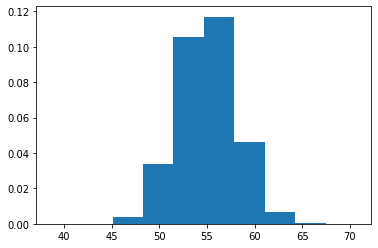

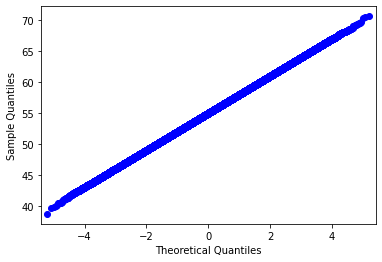

univariate Box Muller transform took 0.9633342470000059 seconds
given: mu = 55, sigma = 3
generated: mu = 54.99968890124071, sigma = 3.0008393954735633


In [ ]:
BoxMuller(55,3,10000000)

In [ ]:
def BoxMullerAlt(n,mu=0,sigma=1):

  # start counter
  tic = time.perf_counter() 

  # simulate random uniformly distributed data of size n
  u1, u2 = np.random.uniform(0,1,n), np.random.uniform(0,1,n)

  # apply inverse cdf of exponential to u1
  s = -np.log(1-u1)  

  # transform u2 to theta
  theta = 2*np.pi*u2

  # convert s to r
  r = np.sqrt(2*s)

  # generate z1,z2 from r and theta
  z1, z2 = (r*np.cos(theta)*sigma + mu), (r*np.sin(theta)*sigma + mu)

  # end counter
  toc = time.perf_counter() 

  # plot histogram and scatterplot
  fig = plt.figure(figsize=plt.figaspect(0.4))
  ax = fig.add_subplot(1,2,1)
  ax.hist(z1)
  ax.hist(z2)
  ax = fig.add_subplot(1,2,2)
  ax.scatter(z1,z2,s=0.5)

  # plot qqplot of generated data
  sm.qqplot(z1)
  plt.show()
  sm.qqplot(z2)
  plt.show()

  # extract mean and standard deviation from generated data
  mu_1, sigma_1 = norm.fit(z1)
  mu_2,sigma_2 = norm.fit(z2)

  # print given and generated parameters
  print("univariate alternative Box Muller transform took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated z1: mu = {}, sigma = {}".format(mu_1, sigma_1)) # print generated parameters for z1
  print("generated z2: mu = {}, sigma = {}".format(mu_2, sigma_2)) # for z2

In [ ]:
BoxMullerAlt(n=10000000,mu=55,sigma=3)

## Central Limit Theorem

Let $X_i$ be the $i$th random sample of size $n$ from any distribution, including one that is unknown. Let $\bar{X_i}$ be the sample mean of the $i$th sample. As $n$ increases, $\bar{X} \sim normal(\mu_x, \frac{\sigma_x}{\sqrt{n}})$ where $\sigma_x$ is the mean of $X$ and $\sigma_x$ is the standard deviation of X. 

We can simulate a normal distribution by simulating sample means. Since the sample means will have a normal distribution as the size of the sample increases, we can standardize and then translate by the desired mu and scale by the desired sigma. 

In [ ]:
def CentralLimitTheorem(mu,sigma,n_means,n_samples):
  
  # start counter
  tic = time.perf_counter() 

  # generate data
  matrix = np.random.uniform(0,1,size=(n_means,n_samples))
  
  # calculcate sample means
  sampleMeans = matrix.sum(axis=0)/n_samples

  # standardize
  mean = np.mean(sampleMeans)
  sd = np.std(sampleMeans)
  standard = (sampleMeans - mean)/sd

  # scale by sigma, translate by mu
  normal = standard*sigma+mu
  
  # end counter
  toc = time.perf_counter() 

  # plot histogram of generated data
  plt.hist(normal)
  plt.show()

  # plot qqplot of generated data
  sm.qqplot(normal)
  plt.show()

  # mean and standard deviation from generated data
  mu_new = np.mean(normal)
  sigma_new = np.std(normal)

  # print given and generated parameters
  print("univariate CLT took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters

In [ ]:
CentralLimitTheorem(55,3,100,10000000)

In [ ]:
matrix = np.array([[1,0],[2,1]])
matrix.sum(axis=0)

# Multivariate Gaussian Distribution

## Simulating Multivariate Gaussian Data from Univariate Data


In the univariate case, to transform the standard normal distribution, $x \sim normal(0,1)$, to any normal distribution with mean $\mu$ and standard deviation $\sigma$, we add the mean and multiply by the variance to get a variable $y = \mu + \sigma x$, which is distributed as $y\sim N(\mu,\sigma)$ as desired. 

A vector from the multivariate normal distribution in $\mathbb{R}^d$ is $x \sim N(\mu,\Sigma)$ where $x,\mu\in\mathbb{R}^d$ and $\Sigma \in \mathbb{R}^{d\times d}$. The standard normal case is when $\mu$ is the zero vector and $\Sigma = I_d$. 

We can express a sample from the multivariate standard normal distribution as $X \in \mathbb{R}^{d\times n}$ where $X$ is a matrix of $d$ standard normal distributions of size $n$, or each column of $X$ is a sample. 

To change the mean and standard deviation as we did in the univariate case, we can compute $Y = \mu + \Sigma^{1/2} X$, where $\mu \in \mathbb{R}^{d\times n}$ is the $d$-dimensional target mean vector replicated $n$ times for the $n$ samples and $\Sigma $ is the target $d\times d$ covariance matrix. 

To simulate a $d$-dimensional multivariate Gaussian distribution, we
1. Simulate $d$ standard normal distributions of size $n$ (we used the Box Muller Transform and the Inverse Transform Sampling methods: the fastest from the univariate case)
2. Verify that $\Sigma$ is a valid covariance matrix by checking the following: (1) symmetry (2) nonnegative diagonals (3) positive semi definite  
3. Compute $\Sigma ^{\frac{1}{2}}$ using the eigenvalue decomposition of the covariance matrix, $\Sigma = U \Lambda U^T$, where $\Lambda$ is a diagonal matrix whose entries are the eigenvalues of $\Sigma$ and U is an orthonormal matrix of eigenvectors such that $U^TU=I$. 
Since 
$$(U \Lambda^{\frac{1}{2}} U^T)(U \Lambda^{\frac{1}{2}} U^T) = U \Lambda^{\frac{1}{2}}\Lambda^{\frac{1}{2}} U^T = U^T\Lambda U = \Sigma= \Sigma ^{\frac{1}{2}}\Sigma ^{\frac{1}{2}},$$
we can equate the RHS and LHS to get $ \Sigma ^{\frac{1}{2}} = U \Lambda^{\frac{1}{2}} U^T $. 
4. Calculate the new sample, $Y = \mu + \Sigma ^{1/2} X$, with mean $\mu$ and covariance $\Sigma$.

## Transforming from Standard to General Multivariate Gaussian

Let $x_1,x_2,\ldots,x_k \sim N(0,1)$ and be independent. The joint distribution of X = [$x_1,x_2,\ldots,x_k$]  is 

\begin{align}
f_X(x)
&= f(x_1)f(x_2)...f(x_k)\\
&= \underbrace{(2\pi)^{-\frac{1}{2}}(2\pi)^{-\frac{1}{2}}\ldots(2\pi)^{-\frac{1}{2}}}_{k \text{ times}} \underbrace{e^{-\frac{1}{2}x_1^2}e^{-\frac{1}{2}x_2^2}\ldots^{-\frac{1}{2}x_k^2}}_{k \text{ times}}\\
&= (2\pi)^{\frac{-k}{2}} e^{\sum_{i=1}^{k} -\frac{1}{2}x_i^2} \\
&= \frac{}{\sqrt{(2\pi)^k}} exp(-\frac{1}{2}x^Tx) \\
\end{align}

Let X be a k dimensional standard multivariate normal, $\mu$ be a k-dimension vector, and $\Sigma$ be a kxk PSD matrix. Define $Y=\mu + \Sigma^{1/2} X$. We will prove that

$$  f_Y(y) = \frac{}{\sqrt{(2\pi)^k |\Sigma|}} exp\{-\frac{1}{2}(y-\mu)^T \Sigma^{-1} (y-\mu)\} $$

Y defined above is called the multivariate normal vector with mean $\mu$ and covariance $\Sigma$, Y  $\sim N(\mu,\Sigma)$

To transform from a standard to general multivariate gaussian, we apply the following transformation:
$Y= \mu + \Sigma^{1/2} X$. 
Solving for X, 

$$X = v(Y) = \Sigma^{-1/2}(Y-\mu)$$

The pdf of Y is given by:
$$g(Y) = f(v(Y))*|J|$$ where J is the determinant of $\frac{dX}{dY}$, and $\frac{dX}{dY} = \Sigma^{-\frac{1}{2}}$. 
We can confirm this determinant by multiplying out and differentiating the terms. We have
$$X =\begin{bmatrix}X_1\\ \vdots \\ X_k\end{bmatrix}, Y =\begin{bmatrix}Y_1\\\vdots\\ Y_k\end{bmatrix}, \mu = \begin{bmatrix}\mu_1\\ \vdots \\\mu_k\end{bmatrix}, \Sigma^{-1/2}=\begin{bmatrix}s_{11}&\ldots&s_{1k}\\\vdots&\ddots&\vdots\\s_{k1}&\ldots&s_{kk}\end{bmatrix}$$
Then, multiplying out $X = \Sigma^{-1/2}(Y-\mu)$ is equivalent to
\begin{align}
\begin{bmatrix} X_1\\\vdots\\ X_k \end{bmatrix} 
&= \begin{bmatrix}s_{11}&\ldots&s_{1k}\\\vdots&\ddots&\vdots\\s_{k1}&\ldots&s_{kk}\end{bmatrix}\left(\begin{bmatrix}Y_1\\\vdots\\ Y_k\end{bmatrix}-\begin{bmatrix}\mu_1\\\vdots\\ \mu_k\end{bmatrix}\right)\\
&=\begin{bmatrix}s_{11}(Y_1-\mu_1) + s_{12}(Y_2-\mu_2)+\ldots +s_{1k}(Y_k-\mu_k)\\\vdots\\ s_{k1}(Y_1-\mu_1) + s_{k2}(Y_2-\mu_2)+\ldots +s_{kk}(Y_k-\mu_k)\end{bmatrix}
\end{align}

Note that each element $X_i$ of $X$ is now defined by the function
$$X_i(Y_1,\ldots,Y_k) = s_{i1}(Y_1-\mu_1) + \ldots + s_{ij}(Y_j-\mu_j)+\ldots +s_{ik}(Y_k-\mu_k)$$

Differentiating this element gives

\begin{align}
\frac{dX_i}{dY_j} &= \frac{d}{dY_j}\left[\underbrace{s_{i1}(Y_1-\mu_1) + \ldots }_{\text{const. w.r.t. } Y_j} + s_{ij}(Y_j-\underbrace{\mu_j}_{\text{const.}})+\ldots +\underbrace{s_{ik}(Y_k-\mu_k)}_{\text{const.}} \right]\\
&= 0 + \ldots + s_{ij}(1 - 0) + \ldots + 0\\
&= s_{ij}
\end{align}

We now differentiate the vector $X$ with respect to $Y$. It follows from our differentiation of an arbitrary element of $X$ with respect to an arbitrary element of $Y$ that

$$\frac{dX}{dY} = \begin{bmatrix}\frac{dX_1(Y_1,\ldots,Y_k)}{dY_1}&\ldots&\frac{dX_1(Y_1,\ldots,Y_k)}{dY_k}\\\vdots&\ddots &\vdots\\
\frac{dX_k(Y_1,\ldots,Y_k)}{dY_1}&\ldots&\frac{dX_k(Y_1,\ldots,Y_k)}{dY_k} \end{bmatrix} =\begin{bmatrix}s_{11}&\ldots&s_{1k}\\\vdots&\ddots&\vdots\\s_{k1}&\ldots&s_{kk}\end{bmatrix}= \Sigma^{-1/2}$$

as desired.

We now compute the remaining term.

\begin{align}
f(v(Y))
&= f(\Sigma^{-\frac{1}{2}}(Y-\mu))\\
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}[\Sigma^{-\frac{1}{2}}(Y-\mu)]^T [\Sigma^{-\frac{1}{2}}(Y-\mu)] \}  \\
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}
(Y-\mu)^T (\Sigma^{-\frac{1}{2}})^T  \Sigma^{-\frac{1}{2}}(Y-\mu) \}\\
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}
(Y-\mu)^T (U \Lambda ^{-\frac{1}{2}}U^T)^T  (U \Lambda ^{-\frac{1}{2}}U^T)(Y-\mu) \}\\
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}
(Y-\mu)^T (U (\Lambda ^{-\frac{1}{2}})^T U^T)  (U \Lambda ^{-\frac{1}{2}}U^T)(Y-\mu) \}\\
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}
(Y-\mu)^T U \Lambda ^{-\frac{1}{2}} 
(U^T  U) \Lambda ^{-\frac{1}{2}}U^T(Y-\mu) \}\\
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}
(Y-\mu)^T U \Lambda ^{-\frac{1}{2}} 
(I) \Lambda ^{-\frac{1}{2}}U^T(Y-\mu) \}\\
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}
(Y-\mu)^T U (\Lambda ^{\frac{1}{2}} 
\Lambda ^{\frac{1}{2}})^{-1} U^T(Y-\mu) \}\\
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}
(Y-\mu)^T U (\Lambda)^{-1} U^T(Y-\mu) \}\\
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}
(Y-\mu)^T \Sigma^{-1} (Y-\mu) \}\\
\end{align}

Then the pdf of Y is

\begin{align}
g(Y)
&= \frac{}{\sqrt{(2\pi)^k}} exp\{-\frac{1}{2}
(Y-\mu)^T \Sigma^{-1} (Y-\mu) \} |det(\Sigma^{-\frac{1}{2}})|\\
&= \frac{}{\sqrt{(2\pi)^k det(\Sigma)}} exp\{-\frac{1}{2}
(Y-\mu)^T \Sigma^{-1} (Y-\mu) \} \\
\end{align}






## Inverse Transform Sampling

In [ ]:
np.random.seed(000)

# helper function to determine if inputted cov_matrix is valid covariance matrix
def is_cov_mat(x,tol=1e-8):

  # check if matrix is symmetric
  if np.array_equal(x,x.T): 

    # check if diagonal entries are non-negative  
    if any(n < 0 for n in x.diagonal()):
      return False
    
    # check if matrix is positive semi-definite
    else:      
      E = np.linalg.eigvalsh(x)
      return np.all(E > -tol)   
  else:
     return False

# generate sample from multivariate normal distribution using Inverse Transform Sampling
def multiNormalSample_ITS(mu, cov_matrix, n_samples, n_dim):
  if is_cov_mat(cov_matrix):
    # start counter
    tic = time.perf_counter() 
  
    # initialize sample matrix as zeros
    z = np.zeros((n_dim,n_samples)) 

    # populate matrix independently with values from the univariate standard normal
    for d in list(range(0,n_dim)):
      u = np.random.uniform(0, 1, n_samples)
      z[d] = norm.ppf(u)
    
    # compute square root of covariance matrix through eigenvalue decomposition
    eigval, eigvec = np.linalg.eig(cov)
    print(eigval)
    print(eigvec)
    eigval_sqrt = np.diag(np.sqrt(eigval))
    print(eigval_sqrt)
    cov_sqrt = np.matmul(np.matmul(eigvec, eigval_sqrt),eigvec.T)

    # compute 
    x = np.matmul(cov_sqrt,z) + mu 
  
    # end counter
    toc = time.perf_counter()
  
    # print time taken
    print("multivariate sampling took {} seconds".format(toc - tic)) 
    
    # print eigenvalues
    print("the eigenvalues of the covariance matrix were {}".format(eigval)) 

    return x

  else:
    return("Inputted covariance matrix is invalid")

[1.5 0.5]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[[1.22474487 0.        ]
 [0.         0.70710678]]
multivariate sampling took 0.046631197000010616 seconds
the eigenvalues of the covariance matrix were [1.5 0.5]


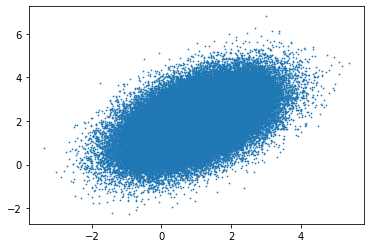

In [ ]:
np.random.seed(000)
# example means and covariance matrix
mu = np.array([[1,2]]).T
cov = np.array([[1,0.5],[0.5,1]])

multi = multiNormalSample_ITS(mu = mu, cov_matrix = cov, n_samples = 100000, n_dim = 2)
plt.scatter(multi[0],multi[1],s=0.5)
plt.show()

# multiNormalSample_ITS(mu = mu, cov_matrix = cov, n_samples = 100000, n_dim = 2)

Changing eigenvalue:
The larger the eigenvalue, the greater the spread of the data.

[ 0.4950005 50.5049995]
[[-0.9949382  -0.10048866]
 [ 0.10048866 -0.9949382 ]]
[[0.70356272 0.        ]
 [0.         7.10668696]]
multivariate sampling took 0.04221135600005255 seconds
the eigenvalues of the covariance matrix were [ 0.4950005 50.5049995]


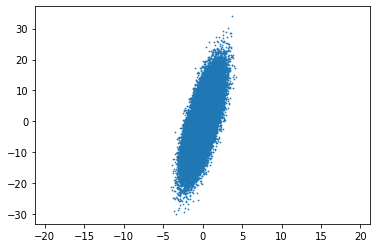

In [ ]:
np.random.seed(000)
# example means and covariance matrix
mu = np.array([[0,0]]).T
cov = np.array([[1,5],[5,50]])

multi = multiNormalSample_ITS(mu = mu, cov_matrix = cov, n_samples = 100000, n_dim = 2)
plt.scatter(multi[0],multi[1],s=0.5)
plt.xlim([-3*np.sqrt(cov[1,1]),3*np.sqrt(cov[1,1])])
plt.show()

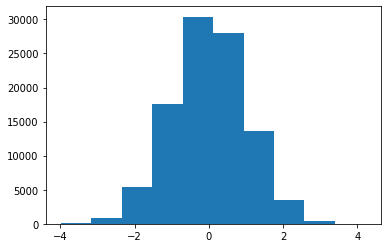

In [ ]:
# plot histogram of first dimension
plt.hist(multi[0])
plt.show()

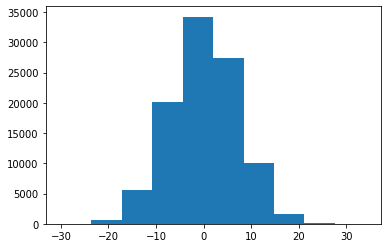

In [ ]:
# plot histogram of second dimension
plt.hist(multi[1])
plt.show()

## Box Muller

In [2]:
# generate sample from multivariate normal distribution using Box Muller Transform
def multiNormalSample_BM(mu, cov_matrix, n_samples, n_dim):
  if is_cov_mat(cov_matrix):
    # start counter
    tic = time.perf_counter() 
  
    # initialize sample matrix as zeros
    z = np.zeros((n_dim,n_samples)) 

    # populate matrix independently with values from the univariate standard normal
    for d in list(range(0,n_dim)):
      # simulate theta and r
      theta = np.random.uniform(0,2*np.pi,n_samples)
      r = np.sqrt(2*np.random.exponential(1,n_samples))

     # calculcate x coordinate
      z[d] = np.cos(theta)*r
    
    # compute square root of covariance matrix through eigenvalue decomposition
    eigval, eigvec = np.linalg.eig(cov_matrix)
    eigval_sqrt = np.diag(eigval*1/2)
    cov_sqrt = np.matmul(np.matmul(eigvec, eigval_sqrt),eigvec.T)

    # print eigenvalues
    # print("eigenvalues of covariance matrix:", eigval)

    # compute 
    x = np.matmul(cov_sqrt,z) + mu 
  
    # end counter
    toc = time.perf_counter()
  
    # print time take
    # print("multivariate sampling took {} seconds".format(toc - tic)) 
    
    return x
  
  else:
    return("Inputted covariance matrix is invalid")

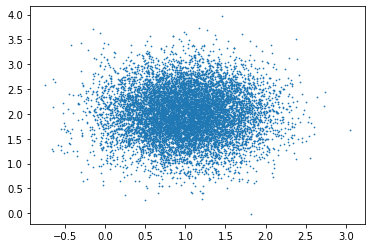

In [9]:
np.random.seed(000)

# example means and covariance matrix
mu = np.array([[1,2]]).T
cov = np.array([[1,0],[0,1]])

multi = multiNormalSample_BM(mu = mu, cov_matrix = cov, n_samples = 10000, n_dim = 2)
plt.scatter(multi[0],multi[1],s=0.5)
plt.show()

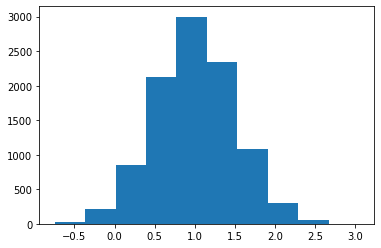

In [10]:
plt.hist(multi[0])
plt.show()

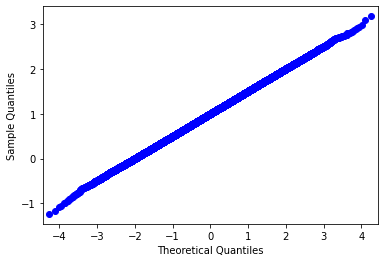

In [ ]:
sm.qqplot(multi[0])
plt.show()

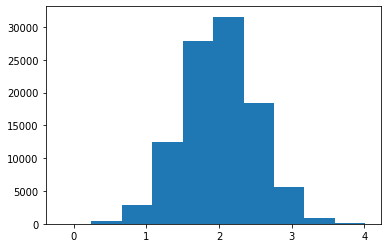

In [ ]:
plt.hist(multi[1])
plt.show()

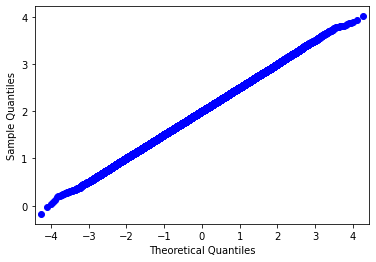

In [ ]:
sm.qqplot(multi[1])
plt.show()

# Generating Data

## Making Blobs
We emulate Python's `make_blobs` function from the `sklearn.datasets` package, which take as input a number, $n$, of blobs to make, and generates data clustered into $n$ blobs of varying shapes and sizes.

In [ ]:
def make_n_blobs(n_samples=100,n_features=2,centers=4,mu_coef=20,sigma_coef=4,user_mu=[],weights=[0.1,0.2,0.3,0.4]):
  # divide total number of samples by number of blobs (no remainder)
  n_samples //= centers # each blob will have this many data points

  # check if user has provided array of mean vectors
  manual_mu = False
  if np.shape(user_mu) == (centers,n_features): # (num blobs x num dimensions)
    # will use user inputted mu
    manual_mu = True
  else:
    # initialize mu
    mu = np.random.randn(n_features,1)

  tic = time.perf_counter() # start timer

  # initialize data matrix
  data = np.zeros((n_features,n_samples * centers))
  data_labels = np.zeros((n_samples * centers, 1))

  # plt.figure()
  # loop through blobs
  for i in range(centers):
    # generate a random invertible matrix
    A = np.random.randn(n_features,n_features) # generate a random matrix

    # compute eigenvalue decomoposition of symmetric matrix
    A_symmetric = A @ A.transpose()
    D, U = np.linalg.eig(A_symmetric)

    # generate eigenvalues close to each other    
    eig_starter = max(2,np.random.randn()) # CONTROLS COVARIANCE
    eigs = np.zeros(n_features) + eig_starter
    for j in range(1,n_features):
      adder = np.random.rand() / sigma_coef
      eigs[j] = eig_starter * (1 + adder)
    eigs = np.array(list(eigs))
    
    # generate PSD matrix with desired eigenvalues
    cov_matrix = U @ np.diag(eigs) @ U.transpose()

    # generate mean vector
    if manual_mu == True:
      mu = np.array(user_mu[i]).reshape((n_features,1)) # use user inputted mu
    else:
      mu += mu_coef * np.random.rand(n_features,1) # CONTROLS MEAN

    # generate data
    X = multiNormalSample_BM(mu, cov_matrix, n_samples, n_features) # use Box Muller    
    data[:,n_samples*i:n_samples*(i+1)] = X
    data_labels[n_samples*i:n_samples*(i+1)] = i

  toc = time.perf_counter() # end timer

  print("from scratch make blobs took {} seconds".format(toc - tic))

  # output full data matrix
  return(data, data_labels)

from scratch make blobs took 0.010429670000007718 seconds


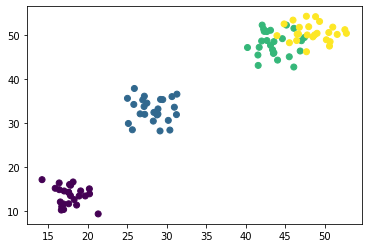

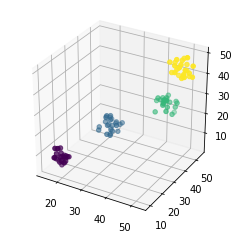

In [ ]:
data, data_labels = make_n_blobs(n_features=3)
plt.scatter(data[0,:],data[1,:],c=data_labels)
fig = plt.figure(figsize=plt.figaspect(1))
ax=fig.add_subplot(projection='3d')
ax.scatter(data[0,:],data[1,:],data[2,:],c=data_labels)


We compare this to the output of the aforementioned pre-built `make_blobs` function, which we find to have a significantly faster runtime than our own.

In [ ]:
from sklearn.datasets import make_blobs
tic = time.perf_counter() # end timer
data,data_labels = make_blobs(n_samples=1000,n_features=500,centers=100)
toc = time.perf_counter() # end timer
print("sklearn make_blobs took {} seconds".format(toc - tic))
# plt.scatter(data[:,0],data[:,1],c=data_labels)

sklearn make_blobs took 0.04751258999976926 seconds


In [ ]:
import random
random.randrange(1,2)

1

In [ ]:
def mixture_make_blobs(n_samples=100,n_features=2,centers=4,
                       mu_coef=20,sigma_coef=4,mu_vec=[],
                       bins=[0.3,0.5,0.8,1]): # NOTE change to bin weights instead of thresholds
                       # NOTE check add to 1; right number of bins; positive weights
                       # NOTE bins default equal weights
                       # NOTE eventual user defined covariances OR eigenvalues 
                       # NOTE (lambda max and lambda min for each blob)
  # if user has not provided valid array of mean vectors, initialize
    manual_mu = True
    if np.shape(mu_vec) != (centers,n_features): # (num blobs x num dimensions)
        manual_mu = False
        mu_vec = []
        mu = np.random.randn(n_features,1)

    tic = time.perf_counter() # start timer

  # initialize covariance vector
    cov_vec = []

  # initialize data matrix
    data = np.zeros((n_features,n_samples))
    data_labels = np.zeros((n_samples, 1))

  # loop through blobs to create means and covariance
    for i in range(centers):
        # generate a random invertible matrix
        A = np.random.randn(n_features,n_features) # generate a random matrix

        # compute eigenvalue decomoposition of symmetric matrix
        A_symmetric = A @ A.transpose()
        D, U = np.linalg.eig(A_symmetric)

        # generate eigenvalues close to each other    
        eig_starter = np.random.uniform(1,2) # CONTROLS COVARIANCE # NOTE lambda min,max
        eigs = np.zeros(n_features) + eig_starter
    for j in range(1,n_features):
        adder = np.random.rand() / sigma_coef # NOTE lambda min,max
        eigs[j] = eig_starter * (1 + adder)
    eigs = np.array(list(eigs))
    
    # generate matrix with desired eigenvalues
    new_A = U @ np.diag(eigs) @ np.linalg.inv(U)

    # generate positive semidefinite covariance matrix
    cov_matrix = new_A @ new_A.transpose()
    cov_vec.append(cov_matrix)

    # generate mean vector
    if manual_mu == False:
        mu += mu_coef * np.random.rand(n_features,1) # CONTROLS MEAN
        mu_vec.append(mu.tolist())

  # loop through samples and draw from mixture distribution
      for j in range(n_samples):
        # generate random number in [0,1]
        alpha = np.random.uniform()

        # identify the index of weighted bin in which alpha belongs
        k = np.digitize(alpha,bins)

        # use mean and covariance from the chosen index
        mu = mu_vec[k]
        cov_matrix = cov_vec[k]

        # generate data
        X = multiNormalSample_BM(mu, cov_matrix, 1, n_features).flatten() # use Box Muller   
        data[:,j] = X
        data_labels[j] = k

    toc = time.perf_counter() # end timer

    print("mixture make blobs took {} seconds".format(toc - tic))
    # output full data matrix
    return(data, data_labels)

eigs [1.85310066 3.6700692 ]
[ 3.43398205 13.4694079 ]
eigs [1.70033469 2.14570008]
[2.89113805 4.60402885]
eigs [1.33809936 2.46552534]
[1.79050989 6.07881521]
eigs [1.35484287 2.51518542]
[1.8355992 6.3261577]
mixture make blobs took 0.0401541780001935 seconds


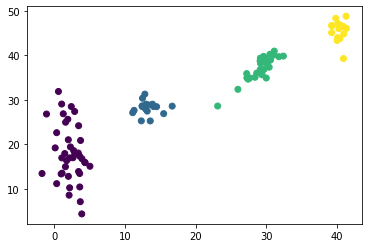

In [ ]:
data, data_labels = mixture_make_blobs(sigma_coef=1)
plt.scatter(data[0,:],data[1,:],c=data_labels)

## Generating Data Uniform on a Sphere

In [8]:
def unif_sphere(n_samples=1000,n_features=3,radius=1,plot=False):
  # generate random normal data
    X = np.zeros((n_features,n_samples))

    for i in range(n_features):
        x=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False).tolist()
        X[i,:] = x

    for i in range(n_samples):
        X[:,i] = X[:,i]/np.linalg.norm(X[:,i],2) * radius

    # if plot != False:
    #   for j in range(n_features):
      # sm.qqplot(X[j,:], dist=scipy.stats.uniform)

    # plot
    if plot != False:
        if n_features == 2:
            plt.scatter(X[0,:],X[1,:])
        elif n_features == 3:
            fig = plt.figure(figsize=plt.figaspect(1))
            ax = fig.add_subplot(projection='3d')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            ax.scatter(X[0,:],X[1,:],X[2,:])
            ax.view_init(0,45)
        else:
            print("no visualization available")

    return(X)

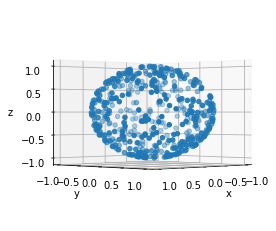

In [10]:
X = unif_sphere(n_samples=500,n_features=3,plot=True)
# X = make_n_blobs(n_samples=100,n_features=2,centers=1,user_mu=np.zeros((1,2)).tolist())

In [ ]:
def uniform_sphere_polar(n_samples = 1000, r = 1,plot=False):

  phi = np.random.uniform(0,np.pi,n_samples)
  theta = np.random.uniform(0,2*np.pi,n_samples) 

  x=r*np.cos(phi)*np.sin(theta)
  y=r*np.sin(phi)*np.sin(theta)
  z=r*np.cos(theta)

  if plot != False:

    sm.qqplot(x, dist=scipy.stats.uniform)
    sm.qqplot(y, dist=scipy.stats.uniform)
    sm.qqplot(z, dist=scipy.stats.uniform)

    fig = plt.figure(figsize=plt.figaspect(1))
    ax=fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x,y,z)
    ax.view_init(0,45)
  
  return(x,y,z)

In [ ]:
def uniform_circle(n_samples = 1000, r =1,plot=False):
  theta = np.random.uniform(0,2*np.pi,n_samples)
  x = r*np.sin(theta)
  y=r*np.cos(theta)

  # sm.qqplot(x, dist=scipy.stats.uniform)

  # sm.qqplot(y, dist=scipy.stats.uniform)

  if plot != False:
    plt.figure()
    plt.scatter(x,y)
    plt.scatter(theta)
  
  return(x,y)

  

In [ ]:
x,y = uniform_circle()

In [ ]:
x,y,z = uniform_sphere_polar(n_samples = 10000, r = 2)

In [ ]:
def uniform_sphere_from_normal(n_samples = 1000, r = 1,plot=False):

  x=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)
  y=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)
  z=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)

  for i in range(n_samples):
    v=[x[i],y[i],z[i]]
    x[i]=x[i]/np.linalg.norm(v)
    y[i]=y[i]/np.linalg.norm(v)
    z[i]=z[i]/np.linalg.norm(v)

  x,y,z = x*r, y*r, z*r

  if plot != False:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax=fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x,y,z)
    ax.view_init(0,45)

  return(x,y,z)

In [ ]:
x,y,z = uniform_sphere_from_normal(n_samples=500, r=2)

## Generating Data Uniform on a Cylinder

In [ ]:
def unif_cylinder(n_samples=1000,radius=1,height=100,n_features=3):
  # NOTE gram schmidt for rotation (given a set of vectors, orthogonalize)
  # use a vector for main axis--userinputted or random
  # for vector based: change of basis w.r.t. new vector 
  # linear transformation to map z axis to new director
  # initialize data matrix
  X = np.zeros((n_features,n_samples))

  circ_dim = n_features - 1
  # generate a 2-d uniformly random circles
  X[:circ_dim,:] = unif_sphere(n_samples=n_samples,n_features=circ_dim,radius=1)
  
  # add uniformly random values of the third dimension to circles
  X[circ_dim,:] = np.random.uniform(0,height,n_samples).tolist()

  fig = plt.figure(figsize=plt.figaspect(0.3))
  ax = fig.add_subplot(1,3,2,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],X[2,:],s=2, alpha=0.2)
  ax.view_init(45,45)

  # ax = fig.add_subplot(1,3,1,projection='3d')
  # ax.set_xlabel('x')
  # ax.set_ylabel('y')
  # ax.set_zlabel('z')
  # ax.scatter(X[0,:],X[2,:],X[3,:],s=1)
  # ax.view_init(45,45)

  ax = fig.add_subplot(1,3,1,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],0,s=1)
  ax.view_init(90,0)

  
  return X

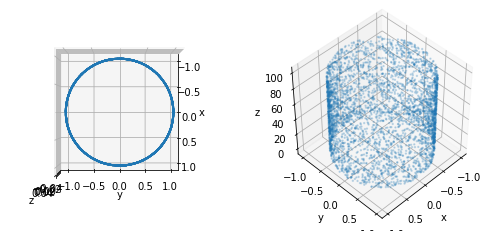

In [ ]:
X = unif_cylinder(n_samples=4000,n_features=3)



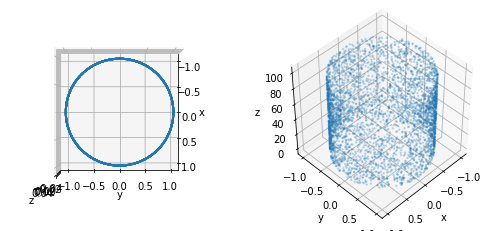

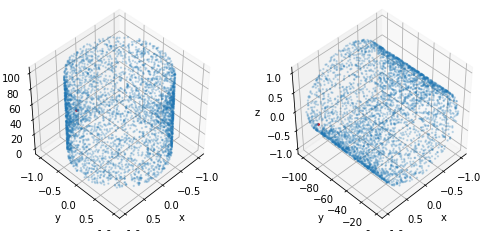

In [ ]:
#Rotating Cylinder
X = unif_cylinder(n_samples=4000,n_features=3)
import copy
def rotateCylinder(X=1,alpha=0, beta=0, gamma=0):

  alpha = np.radians(alpha)
  beta = np.radians(beta)
  gamma = np.radians(gamma)

  u = alpha
  v = beta
  w = gamma

  Xcopy=copy.deepcopy(X)

  m,n = X.shape[0],X.shape[1]
  A = np.zeros((m,n))

  Rx_alpha = np.array([[1,0,0],[0,np.cos(alpha),-np.sin(alpha)],[0,np.sin(alpha),np.cos(alpha)]])
  Ry_beta = np.array([[np.cos(beta),0,np.sin(beta)],[0,1,0],[-np.sin(beta),0,np.cos(beta)]])
  Rz_gamma = np.array([[np.cos(gamma),-np.sin(gamma),0],[np.sin(gamma),np.cos(gamma),0],[0,0,1]])
  R = np.matmul(np.matmul(Rz_gamma,Ry_beta), Rx_alpha)
#   R = np.array([[np.cos(v)*np.cos(w), (np.sin(u)*np.sin(v)*np.cos(w))-(np.cos(u)*np.sin(w)), (np.sin(u)*np.sin(w))+(np.cos(u)*np.sin(v)*np.cos(w))
# ],[np.cos(v)*np.sin(w), (np.cos(u)*np.cos(w))+(np.sin(u)*np.sin(v)*np.sin(w)), (np.cos(u)*np.sin(v)*np.sin(w))-(np.sin(u)*np.cos(w))
# ],[-np.sin(v), np.sin(u)*np.cos(v), np.cos(u)*np.cos(v)
# ]])
  
  for i in list(range(n)):
    A[:,i] = np.matmul(R,X[:,i])
    # A[:,i] = np.matmul(Rz_gamma,X[:,i])

  fig = plt.figure(figsize=plt.figaspect(0.3))

  a = 1
  ax = fig.add_subplot(1,3,1,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:a],X[1,:a],X[2,:a],s=3, alpha=1,color="red")
  ax.scatter(X[0,a:],X[1,a:],X[2,a:],s=2, alpha=0.2)
  ax.view_init(45,45)

  ax = fig.add_subplot(1,3,2,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(A[0,:a],A[1,:a],A[2,:a],s=3, alpha=1,color="red")
  ax.scatter(A[0,a:],A[1,a:],A[2,a:],s=2, alpha=0.2)
  ax.view_init(45,45)


  return 

rotateCylinder(X,90,0,0)


(1.5707963267948966, 1.5707963267948966, 0.0)


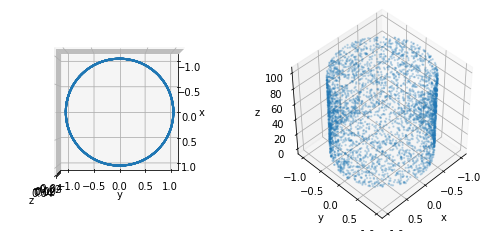

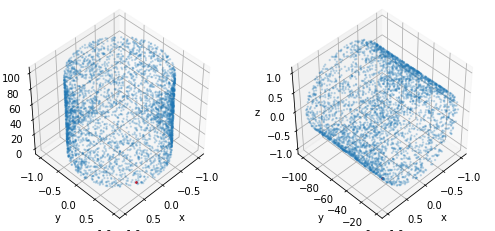

In [ ]:
#Rotating Cylinder

import copy
def rotateCylinderAlongVector(X=1,v=(0,0,0)):

  alpha = v[0]
  beta = v[1]
  gamma = v[2]


  Xcopy=copy.deepcopy(X)

  m,n = X.shape[0],X.shape[1]
  A = np.zeros((m,n))

  Rx_alpha = np.array([[1,0,0],[0,np.cos(alpha),-np.sin(alpha)],[0,np.sin(alpha),np.cos(alpha)]])
  Ry_beta = np.array([[np.cos(beta),0,np.sin(beta)],[0,1,0],[-np.sin(beta),0,np.cos(beta)]])
  Rz_gamma = np.array([[np.cos(gamma),-np.sin(gamma),0],[np.sin(gamma),np.cos(gamma),0],[0,0,1]])
  R = np.matmul(np.matmul(Rz_gamma,Ry_beta), Rx_alpha)

  for i in list(range(n)):
    A[:,i] = np.matmul(R,X[:,i])
    # A[:,i] = np.matmul(Rz_gamma,X[:,i])

  fig = plt.figure(figsize=plt.figaspect(0.3))

  a = 1
  ax = fig.add_subplot(1,3,1,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:a],X[1,:a],X[2,:a],s=3, alpha=1,color="red")
  ax.scatter(X[0,a:],X[1,a:],X[2,a:],s=2, alpha=0.2)
  ax.view_init(45,45)

  ax = fig.add_subplot(1,3,2,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(A[0,:a],A[1,:a],A[2,:a],s=3, alpha=1,color="red")
  ax.scatter(A[0,a:],A[1,a:],A[2,a:],s=2, alpha=0.2)
  ax.view_init(45,45)


  return 

X = unif_cylinder(n_samples=4000,n_features=3)
v = vectorAngles(np.array([0,0,1]))
print(v)
rotateCylinderAlongVector(X,v)

In [ ]:
import math
def vectorAngles(v):
  u = v/np.linalg.norm(v,2)
  alpha = math.acos(u[0])
  beta = math.acos(u[1])
  gamma = math.acos(u[2])
  return alpha,beta,gamma
vectorAngles(np.array([1,0,0]))

(0.0, 1.5707963267948966, 1.5707963267948966)

##Generating Data Uniform on a Square

In [ ]:
def uniform_square(side_length=1,n_samples=1000,center=[0,0],dim=2,angle_degree = 45):
    
    angle = angle_degree* np.pi/180 #degrees to radians 
    dist_from_center = side_length/2
    samples_per_side = math.floor(n_samples/4)
    
    top_x  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    top_y = np.repeat(dist_from_center,samples_per_side)
    top = np.asarray((top_x,top_y)).transpose()
    
    bottom_x  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    bottom_y = np.repeat(-dist_from_center,samples_per_side)
    bottom = np.asarray((bottom_x,bottom_y)).transpose()
    
    left_y  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    left_x = np.repeat(-dist_from_center,samples_per_side)
    left = np.asarray((left_x,left_y)).transpose()
    
    right_y = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    right_x = np.repeat(dist_from_center,samples_per_side)
    right = np.asarray((right_x,right_y)).transpose()
    
    X = np.concatenate((top,bottom,left,right))

    #rotate the square
    for i in range(n_samples):
        point = X[i]
        x = point[0]
        y = point[1]
        #rotation matrix
        X[i][0] = (x*np.cos(angle)) - (y*np.sin(angle))
        X[i][1] = (x*np.sin(angle)) + (y*np.cos(angle))

    #shift shape from the center
    X += center  

    #plot 
    plt.scatter(X[:,0],X[:,1])
    plt.axis("equal")

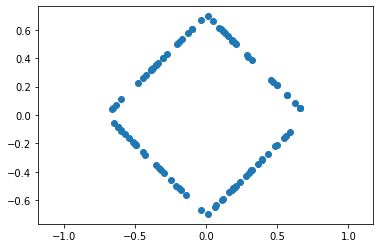

In [ ]:
uniform_square(n_samples=100,center = [0,0],angle_degree=45)

In [ ]:
def cube(side_length=1,n_samples=10000):

  X = np.zeros((3,n_samples))

  X[0,:] = np.random.uniform(0,side_length,n_samples) 
  X[1,:] = np.random.uniform(0,side_length,n_samples) 
  X[2,:] = np.random.uniform(0,side_length,n_samples) 

  fig = plt.figure(figsize=plt.figaspect(1))
  ax = fig.add_subplot(projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],X[2,:])
  ax.view_init(45,45)




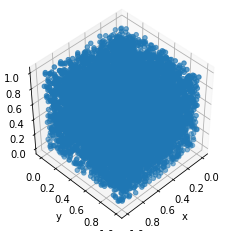

In [ ]:
cube()

In [ ]:
def square(side_length=1,n_samples=1000,dim1=True, dim2= True, dim3 = True, adder = 0,plot=False):

  X = np.zeros((3,n_samples)) + adder

  if dim1 == True:
    X[0,:] = np.random.uniform(0,side_length,n_samples) 
  if dim2 == True:  
    X[1,:] = np.random.uniform(0,side_length,n_samples)
  if dim3 == True:
    X[2,:] = np.random.uniform(0,side_length,n_samples)


  if plot != False:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(X[0,:],X[1,:],X[2,:])
    ax.view_init(45,45)

  return(X)




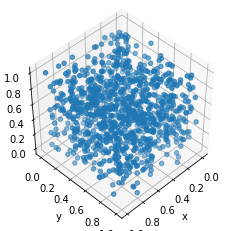

In [ ]:
square()

In [ ]:
def empty_cube(side_length=1,n_samples=10000,center=[0,0,0],dim=2,angle_degree = 45,plot=False):
    
    center = np.array(center).reshape(3,1)
    angle = angle_degree* np.pi/180 #degrees to radians 
    dist_from_center = side_length/2
    samples_per_side = math.floor(n_samples/6)

 
    side1 = square(n_samples=samples_per_side, dim1=False) - dist_from_center
    side2 = square(n_samples=samples_per_side, dim1=False, adder = side_length) - dist_from_center

    side3 = square(n_samples=samples_per_side, dim2=False) - dist_from_center
    side4 = square(n_samples=samples_per_side, dim2=False, adder = side_length) - dist_from_center

    side5 = square(n_samples=samples_per_side, dim3=False) - dist_from_center
    side6 = square(n_samples=samples_per_side, dim3=False, adder = side_length) - dist_from_center

    #verify cube
    X_hollow = np.concatenate((side1,side2,side3,side4),axis=1) + center

    X = np.concatenate((side1,side2,side3,side4,side5,side6),axis=1) + center

    if plot != False:
      fig = plt.figure(figsize=plt.figaspect(0.5))
      ax = fig.add_subplot(1,2,1,projection='3d')
      ax.scatter(X[0,:],X[1,:],X[2,:])
      ax.view_init(45,45)

      ax = fig.add_subplot(1,2,2,projection='3d')
      ax.scatter(X_hollow[0,:],X_hollow[1,:],X_hollow[2,:])
      ax.view_init(90,0)
    
    return(X)


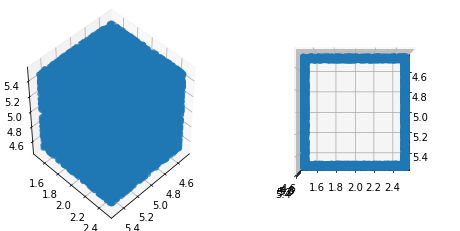

In [ ]:
X = empty_cube(center=[5,2,5],plot=True)

In [ ]:
center = np.array([1,1,1]).reshape(3,1)
np.shape(center)

(3, 1)

# Function Directory



In [1]:
# import packages
import numpy as np
import scipy
from scipy.stats import norm 
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm
import math

## INVERSE TRANSFORM 

# generate sample from normal distribution using inverse transform sampling 
def InverseTransform(mu, sigma, n_samples):

  # start counter
  tic = time.perf_counter() 

  # simulate uniformly randomly distributed data of size n_samples
  u = np.random.uniform(0, 1, n_samples)

  # perform inverse transform sampling, scale by sigma, and translate by mu
  x = norm.ppf(u) * sigma + mu # quantile of standard normal distribution, scaled

  # end counter
  toc = time.perf_counter()

  # plot histogram of generated data
  plt.hist(x)
  plt.show()

  # plot qqplot of generated data
  sm.qqplot(x) #defaut comparison distribution is standard normal
  plt.show()

  # extract mean and standard deviation from generated data
  mu_new, sigma_new = norm.fit(x)

  # print given and generated parameters
  print("univariate inverse transform took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters

  return x

## BOX-MULLER

# generate sample from normal distribution using Box-Muller Transform
def BoxMuller(mu,sigma,n,plot=False):
  
  # start counter
  tic = time.perf_counter() 

  # simulate theta and r
  u1, u2 = np.random.uniform(0,1,n), np.random.uniform(0,1,n)
  r = np.sqrt(-2*np.log(1-u1))
  theta = 2*np.pi*u2

  # calculcate x coordinate
  x = np.cos(theta)*r*sigma + mu

  # end counter
  toc = time.perf_counter() 

  if plot == True:

    # plot histogram of generated data
    plt.hist(x,density=True)
    plt.show()

    # plot qqplot of generated data
    sm.qqplot(x)
    plt.show()

    # mean and standard deviation from generated data
    mu_new, sigma_new = norm.fit(x)
    
    print("univariate Box Muller transform took {} seconds".format(toc - tic))
    print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
    print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters

  return x

def BoxMullerAlt(n,mu=0,sigma=1):

  # start counter
  tic = time.perf_counter() 

  # simulate random uniformly distributed data of size n
  u1, u2 = np.random.uniform(0,1,n), np.random.uniform(0,1,n)

  # apply inverse cdf of exponential to u1
  s = -np.log(1-u1)  

  # transform u2 to theta
  theta = 2*np.pi*u2

  # convert s to r
  r = np.sqrt(2*s)

  # generate z1,z2 from r and theta
  z1, z2 = (r*np.cos(theta)*sigma + mu), (r*np.sin(theta)*sigma + mu)

  # end counter
  toc = time.perf_counter() 

  # plot histogram and scatterplot
  fig = plt.figure(figsize=plt.figaspect(0.4))
  ax = fig.add_subplot(1,2,1)
  ax.hist(z1)
  ax.hist(z2)
  ax = fig.add_subplot(1,2,2)
  ax.scatter(z1,z2,s=0.5)

  # plot qqplot of generated data
  sm.qqplot(z1)
  plt.show()
  sm.qqplot(z2)
  plt.show()

  # extract mean and standard deviation from generated data
  mu_1, sigma_1 = norm.fit(z1)
  mu_2,sigma_2 = norm.fit(z2)

  # print given and generated parameters
  print("univariate alternative Box Muller transform took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated z1: mu = {}, sigma = {}".format(mu_1, sigma_1)) # print generated parameters for z1
  print("generated z2: mu = {}, sigma = {}".format(mu_2, sigma_2)) # for z2


## CENTRAL LIMIT THEOREM

def CentralLimitTheorem(mu,sigma,n_means,n_samples):
  
  # start counter
  tic = time.perf_counter() 

  # generate data
  matrix = np.random.uniform(0,1,size=(n_means,n_samples))
  
  # calculcate sample means
  sampleMeans = matrix.sum(axis=0)/n_samples

  # standardize
  mean = np.mean(sampleMeans)
  sd = np.std(sampleMeans)
  standard = (sampleMeans - mean)/sd

  # scale by sigma, translate by mu
  normal = standard*sigma+mu
  
  # end counter
  toc = time.perf_counter() 

  # plot histogram of generated data
  plt.hist(normal)
  plt.show()

  # plot qqplot of generated data
  sm.qqplot(normal)
  plt.show()

  # mean and standard deviation from generated data
  mu_new = np.mean(normal)
  sigma_new = np.std(normal)

  # print given and generated parameters
  print("univariate CLT took {} seconds".format(toc - tic))
  print("given: mu = {}, sigma = {}".format(mu, sigma)) # print given parameters
  print("generated: mu = {}, sigma = {}".format(mu_new, sigma_new)) # print generated parameters


## MULTIVARIATE INVERSE TRANSFORM

np.random.seed(000)

# helper function to determine if inputted cov_matrix is valid covariance matrix
def is_cov_mat(x,tol=1e-8):

  # check if matrix is symmetric
  if np.array_equal(x,x.T): 

    # check if diagonal entries are non-negative  
    if any(n < 0 for n in x.diagonal()):
      return False
    
    # check if matrix is positive semi-definite
    else:      
      E = np.linalg.eigvalsh(x)
      return np.all(E > -tol)   
  else:
     return False

# generate sample from multivariate normal distribution using Inverse Transform Sampling
def multiNormalSample_ITS(mu, cov_matrix, n_samples, n_dim):
  if is_cov_mat(cov_matrix):
    # start counter
    tic = time.perf_counter() 
  
    # initialize sample matrix as zeros
    z = np.zeros((n_dim,n_samples)) 

    # populate matrix independently with values from the univariate standard normal
    for d in list(range(0,n_dim)):
      u = np.random.uniform(0, 1, n_samples)
      z[d] = norm.ppf(u)
    
    # compute square root of covariance matrix through eigenvalue decomposition
    eigval, eigvec = np.linalg.eig(cov)
    print(eigval)
    print(eigvec)
    eigval_sqrt = np.diag(np.sqrt(eigval))
    print(eigval_sqrt)
    cov_sqrt = np.matmul(np.matmul(eigvec, eigval_sqrt),eigvec.T)

    # compute 
    x = np.matmul(cov_sqrt,z) + mu 
  
    # end counter
    toc = time.perf_counter()
  
    # print time taken
    print("multivariate sampling took {} seconds".format(toc - tic)) 
    
    # print eigenvalues
    print("the eigenvalues of the covariance matrix were {}".format(eigval)) 

    return x

  else:
    return("Inputted covariance matrix is invalid")


## MULTIVARIATE BOX-MULLER

# generate sample from multivariate normal distribution using Box Muller Transform
def multiNormalSample_BM(mu, cov_matrix, n_samples, n_dim):
  if is_cov_mat(cov_matrix):
    # start counter
    tic = time.perf_counter() 
  
    # initialize sample matrix as zeros
    z = np.zeros((n_dim,n_samples)) 

    # populate matrix independently with values from the univariate standard normal
    for d in list(range(0,n_dim)):
      # simulate theta and r
      theta = np.random.uniform(0,2*np.pi,n_samples)
      r = np.sqrt(2*np.random.exponential(1,n_samples))

     # calculcate x coordinate
      z[d] = np.cos(theta)*r
    
    # compute square root of covariance matrix through eigenvalue decomposition
    eigval, eigvec = np.linalg.eig(cov_matrix)
    eigval_sqrt = np.diag(eigval*1/2)
    cov_sqrt = np.matmul(np.matmul(eigvec, eigval_sqrt),eigvec.T)

    # print eigenvalues
    # print("eigenvalues of covariance matrix:", eigval)

    # compute 
    x = np.matmul(cov_sqrt,z) + mu 
  
    # end counter
    toc = time.perf_counter()
  
    # print time take
    # print("multivariate sampling took {} seconds".format(toc - tic)) 
    
    return x
  
  else:
    return("Inputted covariance matrix is invalid")


## MAKE BLOBS

def make_n_blobs(n_samples=100,n_features=2,centers=4,mu_coef=20,sigma_coef=4,user_mu=[],weights=[0.1,0.2,0.3,0.4]):
  # divide total number of samples by number of blobs (no remainder)
  n_samples //= centers # each blob will have this many data points

  # check if user has provided array of mean vectors
  manual_mu = False
  if np.shape(user_mu) == (centers,n_features): # (num blobs x num dimensions)
    # will use user inputted mu
    manual_mu = True
  else:
    # initialize mu
    mu = np.random.randn(n_features,1)

  tic = time.perf_counter() # start timer

  # initialize data matrix
  data = np.zeros((n_features,n_samples * centers))
  data_labels = np.zeros((n_samples * centers, 1))

  # plt.figure()
  # loop through blobs
  for i in range(centers):
    # generate a random invertible matrix
    A = np.random.randn(n_features,n_features) # generate a random matrix

    # compute eigenvalue decomoposition of symmetric matrix
    A_symmetric = A @ A.transpose()
    D, U = np.linalg.eig(A_symmetric)

    # generate eigenvalues close to each other    
    eig_starter = max(2,np.random.randn()) # CONTROLS COVARIANCE
    eigs = np.zeros(n_features) + eig_starter
    for j in range(1,n_features):
      adder = np.random.rand() / sigma_coef
      eigs[j] = eig_starter * (1 + adder)
    eigs = np.array(list(eigs))
    
    # generate matrix with desired eigenvalues
    new_A = U @ np.diag(eigs) @ np.linalg.inv(U)

    # generate positive semidefinite covariance matrix
    cov_matrix = new_A @ new_A.transpose()

    # generate mean vector
    if manual_mu == True:
      mu = np.array(user_mu[i]).reshape((n_features,1)) # use user inputted mu
    else:
      mu += mu_coef * np.random.rand(n_features,1) # CONTROLS MEAN

    # generate data
    X = multiNormalSample_BM(mu, cov_matrix, n_samples, n_features) # use Box Muller    
    data[:,n_samples*i:n_samples*(i+1)] = X
    data_labels[n_samples*i:n_samples*(i+1)] = i

  toc = time.perf_counter() # end timer

  print("from scratch make blobs took {} seconds".format(toc - tic))

  # output full data matrix
  return(data, data_labels)


  ## MAKE BLOBS - MIXTURE MODEL

def mixture_make_blobs(n_samples=100,n_features=2,centers=4,
                       mu_coef=20,sigma_coef=4,mu_vec=[],
                       bins=[0.3,0.5,0.8,1]):
  # if user has not provided valid array of mean vectors, initialize
  manual_mu = True
  if np.shape(mu_vec) != (centers,n_features): # (num blobs x num dimensions)
    manual_mu = False
    mu_vec = []
    mu = np.random.randn(n_features,1)

  tic = time.perf_counter() # start timer

  # initialize covariance vector
  cov_vec = []

  # initialize data matrix
  data = np.zeros((n_features,n_samples))
  data_labels = np.zeros((n_samples, 1))

  # loop through blobs to create means and covariance
  for i in range(centers):
    # generate a random invertible matrix
    A = np.random.randn(n_features,n_features) # generate a random matrix

    # compute eigenvalue decomoposition of symmetric matrix
    A_symmetric = A @ A.transpose()
    D, U = np.linalg.eig(A_symmetric)

    # generate eigenvalues close to each other    
    eig_starter = np.random.uniform(1,2) # CONTROLS COVARIANCE
    eigs = np.zeros(n_features) + eig_starter
    for j in range(1,n_features):
      adder = np.random.rand() / sigma_coef
      eigs[j] = eig_starter * (1 + adder)
    eigs = np.array(list(eigs))
    
    # generate matrix with desired eigenvalues
    new_A = U @ np.diag(eigs) @ np.linalg.inv(U)

    # generate positive semidefinite covariance matrix
    cov_matrix = new_A @ new_A.transpose()
    cov_vec.append(cov_matrix)

    # generate mean vector
    if manual_mu == False:
      mu += mu_coef * np.random.rand(n_features,1) # CONTROLS MEAN
      mu_vec.append(mu.tolist())

  # loop through samples and draw from mixture distribution
  for j in range(n_samples):
    # generate random number in [0,1]
    alpha = np.random.uniform()

    # identify the index of weighted bin in which alpha belongs
    k = np.digitize(alpha,bins)

    # use mean and covariance from the chosen index
    mu = mu_vec[k]
    cov_matrix = cov_vec[k]

    # generate data
    X = multiNormalSample_BM(mu, cov_matrix, 1, n_features).flatten() # use Box Muller   
    data[:,j] = X
    data_labels[j] = k

  toc = time.perf_counter() # end timer

  print("mixture make blobs took {} seconds".format(toc - tic))
  # output full data matrix
  return(data, data_labels)


## GENERATE UNIFORM DATA ON SPHERE
def unif_sphere(n_samples=1000,n_features=3,radius=1,plot=False):
  # generate random normal data
  X = np.zeros((n_features,n_samples))

  for i in range(n_features):
    x=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False).tolist()
    X[i,:] = x

  for i in range(n_samples):
    X[:,i] = X[:,i]/np.linalg.norm(X[:,i]) * radius
 
  if plot != False:
    for j in range(n_features):
      sm.qqplot(X[j,:], dist=scipy.stats.uniform)

  # plot
  if plot != False:
    if n_features == 2:
      plt.scatter(X[0,:],X[1,:])
    elif n_features == 3:
      fig = plt.figure(figsize=plt.figaspect(1))
      ax = fig.add_subplot(projection='3d')
      ax.set_xlabel('x')
      ax.set_ylabel('y')
      ax.set_zlabel('z')
      ax.scatter(X[0,:],X[1,:],X[2,:])
      ax.view_init(0,45)
    else:
      print("no visualization available")

  return(X)

def uniform_sphere_polar(n_samples = 1000, r = 1,plot=False):

  phi = np.random.uniform(0,np.pi,n_samples)
  theta = np.random.uniform(0,2*np.pi,n_samples) 

  x=r*np.cos(phi)*np.sin(theta)
  y=r*np.sin(phi)*np.sin(theta)
  z=r*np.cos(theta)

  if plot != False:

    sm.qqplot(x, dist=scipy.stats.uniform)
    sm.qqplot(y, dist=scipy.stats.uniform)
    sm.qqplot(z, dist=scipy.stats.uniform)

    fig = plt.figure(figsize=plt.figaspect(1))
    ax=fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x,y,z)
    ax.view_init(0,45)
  
  return(x,y,z)

def uniform_circle(n_samples = 1000, r =1,plot=False):
  theta = np.random.uniform(0,2*np.pi,n_samples)
  x = r*np.sin(theta)
  y=r*np.cos(theta)

  # sm.qqplot(x, dist=scipy.stats.uniform)

  # sm.qqplot(y, dist=scipy.stats.uniform)

  if plot != False:
    plt.figure()
    plt.scatter(x,y)
    plt.scatter(theta)
  
  return(x,y)

def uniform_sphere_from_normal(n_samples = 1000, r = 1,plot=False):

  x=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)
  y=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)
  z=BoxMuller(mu=0, sigma=1, n=n_samples,plot=False)

  for i in range(n_samples):
    v=[x[i],y[i],z[i]]
    x[i]=x[i]/np.linalg.norm(v)
    y[i]=y[i]/np.linalg.norm(v)
    z[i]=z[i]/np.linalg.norm(v)

  x,y,z = x*r, y*r, z*r

  if plot != False:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax=fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(x,y,z)
    ax.view_init(0,45)

  return(x,y,z)


## GENERATE UNIFORM DATA ON CYLINDER

def unif_cylinder(n_samples=1000,radius=1,height=100,n_features=3):
  # initialize data matrix
  X = np.zeros((n_features,n_samples))

  circ_dim = n_features - 1
  # generate a 2-d uniformly random circles
  X[:circ_dim,:] = unif_sphere(n_samples=n_samples,n_features=circ_dim,radius=1)
  
  # add uniformly random values of the third dimension to circles
  X[circ_dim,:] = np.random.uniform(0,height,n_samples).tolist()

  fig = plt.figure(figsize=plt.figaspect(0.5))
  ax = fig.add_subplot(1,2,2,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],X[2,:])
  ax.view_init(90,0)

  ax = fig.add_subplot(1,2,1,projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],X[2,:])
  ax.view_init(45,45)
  return(ax)

## GENERATE UNIFORM DATA ON SQUARE

def uniform_square(side_length=1,n_samples=1000,center=[0,0],dim=2,angle_degree = 45):
    
    angle = angle_degree* np.pi/180 #degrees to radians 
    dist_from_center = side_length/2
    samples_per_side = math.floor(n_samples/4)
    
    top_x  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    top_y = np.repeat(dist_from_center,samples_per_side)
    top = np.asarray((top_x,top_y)).transpose()
    
    bottom_x  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    bottom_y = np.repeat(-dist_from_center,samples_per_side)
    bottom = np.asarray((bottom_x,bottom_y)).transpose()
    
    left_y  = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    left_x = np.repeat(-dist_from_center,samples_per_side)
    left = np.asarray((left_x,left_y)).transpose()
    
    right_y = np.random.uniform(0,side_length,samples_per_side) - dist_from_center
    right_x = np.repeat(dist_from_center,samples_per_side)
    right = np.asarray((right_x,right_y)).transpose()
    
    X = np.concatenate((top,bottom,left,right))

    #rotate the square
    for i in range(n_samples):
        point = X[i]
        x = point[0]
        y = point[1]
        #rotation matrix
        X[i][0] = (x*np.cos(angle)) - (y*np.sin(angle))
        X[i][1] = (x*np.sin(angle)) + (y*np.cos(angle))

    #shift shape from the center
    X += center  

    #plot 
    plt.scatter(X[:,0],X[:,1])
    plt.axis("equal")


def square(side_length=1,n_samples=1000,dim1=True, dim2= True, dim3 = True, adder = 0,plot=False):

  X = np.zeros((3,n_samples)) + adder

  if dim1 == True:
    X[0,:] = np.random.uniform(0,side_length,n_samples) 
  if dim2 == True:  
    X[1,:] = np.random.uniform(0,side_length,n_samples)
  if dim3 == True:
    X[2,:] = np.random.uniform(0,side_length,n_samples)


  if plot != False:
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(X[0,:],X[1,:],X[2,:])
    ax.view_init(45,45)

  return(X)


## GENERATE UNIFORM DATA ON CUBE
## FILLED CUBE

def cube(side_length=1,n_samples=10000):

  X = np.zeros((3,n_samples))

  X[0,:] = np.random.uniform(0,side_length,n_samples) 
  X[1,:] = np.random.uniform(0,side_length,n_samples) 
  X[2,:] = np.random.uniform(0,side_length,n_samples) 

  fig = plt.figure(figsize=plt.figaspect(1))
  ax = fig.add_subplot(projection='3d')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.scatter(X[0,:],X[1,:],X[2,:])
  ax.view_init(45,45)

## EMPTY CUBE

def empty_cube(side_length=1,n_samples=10000,center=[0,0,0],dim=2,angle_degree = 45,plot=True):
    
    center = np.array(center).reshape(3,1)
    angle = angle_degree* np.pi/180 #degrees to radians 
    dist_from_center = side_length/2
    samples_per_side = math.floor(n_samples/6)

 
    side1 = square(n_samples=samples_per_side, dim1=False) - dist_from_center
    side2 = square(n_samples=samples_per_side, dim1=False, adder = side_length) - dist_from_center

    side3 = square(n_samples=samples_per_side, dim2=False) - dist_from_center
    side4 = square(n_samples=samples_per_side, dim2=False, adder = side_length) - dist_from_center

    side5 = square(n_samples=samples_per_side, dim3=False) - dist_from_center
    side6 = square(n_samples=samples_per_side, dim3=False, adder = side_length) - dist_from_center

    #verify cube
    X_hollow = np.concatenate((side1,side2,side3,side4),axis=1) + center

    X = np.concatenate((side1,side2,side3,side4,side5,side6),axis=1) + center

    if plot != False:
      fig = plt.figure(figsize=plt.figaspect(0.5))
      ax = fig.add_subplot(1,2,1,projection='3d')
      ax.scatter(X[0,:],X[1,:],X[2,:])
      ax.view_init(45,45)

      ax = fig.add_subplot(1,2,2,projection='3d')
      ax.scatter(X_hollow[0,:],X_hollow[1,:],X_hollow[2,:])
      ax.view_init(90,0)
    
    return(X)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
